# trainsegmentation: colony counting
This is a tutorial on using trainsegmentation for colony counting. The test data provided is *E. coli* on LB agar plates scanned by a benchtop scanner with six images to a plate.

### Step 1: Import the training data
Download the test data into the working directory. We'll define a function to import it.

In [1]:
import trainsegmentation as tseg

#locations of training image
trainimg = './colony_data/plate_01.tif'

#list of binary images for labeling
labelimg = ['./colony_data/training_data/plate_01_colony.tif','./colony_data/training_data/plate_01_not_colony.tif']

#load training data (images and labels)
#generates list of images and corresponding labels (each mask is given a number progressively to generate label (e.g. 1,2))
trainimg, labels = tseg.import_training_data(trainimg,labelimg,ext = '.tif')



We can visualize the labels using pyplot

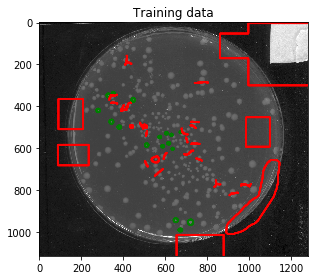

In [2]:
from matplotlib import pyplot as plt

fig,ax = plt.subplots(1,1,tight_layout = True)
ax.imshow(trainimg[0], cmap = 'gray')
ax.contour(labels[0] == 1, colors = 'g')
ax.contour(labels[0] == 2, colors = 'r')
ax.set_title('Training data')
plt.show()

### Step 2: get image features 
The next step is to use the data to get features 

In [3]:
#define training feature sets 
featureselect = [tseg.Membrane_projections,tseg.Difference_of_Gaussians,tseg.Gaussian_blur,tseg.Sobel_filter]

#save the training data so we can take a closer look later
savedata = './colonydata.pkl'

#get training features for given images and labels
traininglabels, trainingfeatures = tseg.get_training_data(trainimg,labels,featureselect,savedatafile = savedata)

### Step 3: train classifier
Then we use the feature set to train the classifier. The defualt classifier is a Random Forest Classifier. We'll also save the classifier to use later.

In [36]:
#name to save classifier as pickle file
saveclassifier = './colonyclassifier.pkl'
clf = tseg.train_classifier(traininglabels,trainingfeatures,featureselect,saveclftofile = saveclassifier)

### Step 4: check the results of the classifier
We're going to classify using a probability mask that we then use thresholding to create the binary mask.

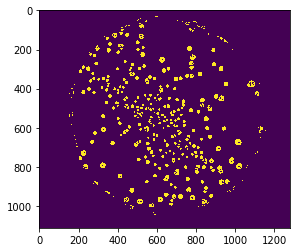

In [5]:
from skimage.io import imread
from skimage import filters

img = imread('./colony_data/plate_01.tif')
rawresult = tseg.classify_image_label_probability(img,clf,featureselect)
result = tseg.threshold_mask(rawresult, threshmethod = filters.threshold_isodata)
plt.imshow(result)

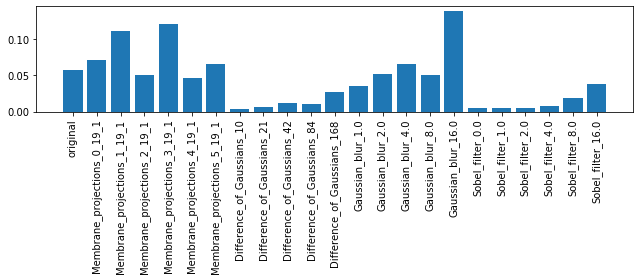

In [6]:
#we can load in all the training data from earlier and take a closer look
meta, FEATURES, LABELS, featureselect = tseg.load_training_features(savedata)

fig, ax = plt.subplots(1, 1, figsize=(9, 4))
ydata = list(clf.feature_importances_)
xdata = list(meta[0])
ax.bar(xdata,ydata)
ax.set_xticklabels(xdata,rotation = 90)
fig.tight_layout()

### Step 5: count colonies
The mask is good enough to count our colonies so long as we have a size requirement. Lets say 50-1000 pixels. 

We can use ndimage to count the colonies.

In [17]:
from scipy import ndimage
import numpy as np

#first label all the discrete areas
label, nlabels = ndimage.label(result)

#then exclude by size
AREA = ndimage.sum(label*0 + 1.0, label, list(range(nlabels)))
#get matrix of cells within size range
goodcell = np.where((AREA > 50) & (AREA < 1000))[0]

#create zeroes array to write labels to
newlabel = label*0

#go through image and rewrite only labels within size range
for l in goodcell:
    loc = np.where(label == l)
    newlabel[loc] = l
    
print(len(np.unique(newlabel)), ' colonies')
 

284  colonies


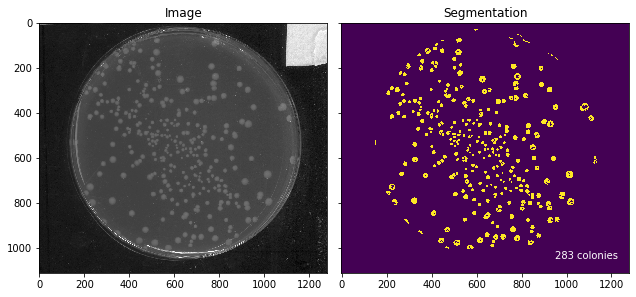

In [23]:
# visualize with pyplot

fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9, 4))
ax[0].imshow(img, cmap = 'gray')
ax[0].set_title('Image')
ax[1].imshow(newlabel > 0)
ax[1].set_title('Segmentation')
ax[1].text(950,1050, str(len(goodcell)) + ' colonies',color = 'white')
fig.tight_layout()


### Step 6: Test on all the other plates

Now we create a function that we can run the classifier and count the remaining plates. Within the function we're going to set a limit for to many to count (TMTC), which we'll conservatively set at 300. Then we'll run the function on all the tiff files in colony_data and save the results to a csv with pandas.

In [33]:
def count_plate(file,clf,featureselect):
    #import file as image
    img = imread(file)
    
    #classifiy image
    rawresult = tseg.classify_image_label_probability(img,clf,featureselect)
    result = tseg.threshold_mask(rawresult, threshmethod = filters.threshold_isodata)

    #first label all the discrete areas
    label, nlabels = ndimage.label(result)

    #then exclude by size
    AREA = ndimage.sum(label*0 + 1.0, label, list(range(nlabels)))
    #get matrix of cells within size range
    goodcell = np.where((AREA > 50) & (AREA < 1000))[0]

    if len(goodcell) < 300:
        #return only the count (length of goodcell) if not visualizing
        return(len(goodcell))
    else:
        return('TMTC')

In [37]:
#import classifier if we didn't train it in this session
#name to save classifier to import
saveclassifier = './colonyclassifier.pkl'
clf = tseg.load_classifier(saveclassifier)

In [ ]:
#get a list of all the image filenames
import glob
filenames = glob.glob('./colony_data/*.tif')

#make a list with counts for all the plates
counts = [count_plate(file,clf,featureselect) for file in filenames]


In [35]:
#use pandas to save and export the data
import pandas as pd

df = pd.DataFrame()
df['Plate'] = filenames
df['Counts'] = counts
df.to_csv('./colony_data/counts.csv')